In [1]:
import numpy as np
import laspy
from TronGisPy import GisIO, CRS, Normalizer, Interpolation
import CSF 
import os, sys, gc, subprocess # file system package
import pickle, json, shutil, itertools # file processing basic package
import laspy, PySaga, gdal # geo package
#import cv2 # open computer vision package
import pandas as pd
import geopandas as gpd
import numba
from scipy.stats import entropy
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances, pairwise_distances_argmin
from util.las import *
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [2]:
%%time
las_fp = os.path.join("data", "123.las")
ground_las_fp = os.path.join("tmp", "classified_ground.las")

X_ref_fp = "./tmp/street_X_ref.tif"
X_ref_ground_fp = "./tmp/ground_X_ref.tif"
# las_classified_path = "./tmp/classified_ground.las"
street_las = CloudPoint(las_fp)
ground_las = CloudPoint(ground_las_fp)

Wall time: 3.81 s


In [3]:
resolution = 0.05
pad = resolution / 2
x_min, x_max, y_min, y_max = street_las.get_las_boundary(return_poly=False)
x_min, x_max = x_min - pad, x_max + pad
y_min, y_max = y_min - pad, y_max + pad
geo_transform = (x_min, resolution, 0, y_max, 0, -resolution)
wkt_3826 = CRS.get_wkt_from_epsg(3826)
cols = int((x_max - x_min) // resolution) + 1
rows = int((y_max - y_min) // resolution) + 1
X = np.random.rand(rows, cols)
GisIO.write_output_tif(X, X_ref_fp, geo_transform=geo_transform, projection=wkt_3826, gdaldtype=gdal.GDT_Float32)
X_ref = GisIO.get_nparray(X_ref_fp)
print(X_ref.shape)

(3053, 3256, 1)


In [4]:
GisIO.write_output_tif(X, X_ref_ground_fp, geo_transform=geo_transform, projection=wkt_3826, gdaldtype=gdal.GDT_Float32)
X_ground_ref = GisIO.get_nparray(X_ref_ground_fp)
print(X_ground_ref.shape)

(3053, 3256, 1)


In [5]:
%%time
x_min, x_max, y_min, y_max = street_las.get_las_boundary(return_poly=False)
x_min, x_max = x_min - pad, x_max + pad
y_min, y_max = y_min - pad, y_max + pad
geo_transform = (x_min, resolution, 0, y_max, 0, -resolution)

las_data = np.array([street_las.data[i] for i in street_las.using_attr]).T
X_ref = GisIO.get_nparray(X_ref_fp)
cols, rows, bands, _, _, _, _ = GisIO.get_geo_info(X_ref_fp)
X_ref_extent = GisIO.get_extent(X_ref_fp, False)

las_npidxs = CRS.numba_transfer_group_coord_to_npidx(las_data, geo_transform) # Wall time: 35 s
las_npidxs, las_npidxs.shape

Wall time: 28.1 s


(array([[2409,  769],
        [2480,  771],
        [2490,  785],
        ...,
        [1408, 2321],
        [1487, 2468],
        [1383, 2480]], dtype=int64),
 (23628925, 2))

In [6]:
%%time
x_min, x_max, y_min, y_max = ground_las.get_las_boundary(return_poly=False)
x_min, x_max = x_min - pad, x_max + pad
y_min, y_max = y_min - pad, y_max + pad
geo_transform = (x_min, resolution, 0, y_max, 0, -resolution)

las_ground_data = np.array([ground_las.data[i] for i in ground_las.using_attr]).T
X_ground_ref = GisIO.get_nparray(X_ref_ground_fp)
cols, rows, bands, _, _, _, _ = GisIO.get_geo_info(X_ref_ground_fp)
X_ground_ref_extent = GisIO.get_extent(X_ref_ground_fp, False)

las_ground_npidxs = CRS.numba_transfer_group_coord_to_npidx(las_ground_data, geo_transform) # Wall time: 35 s
las_ground_npidxs, las_ground_npidxs.shape

Wall time: 16.2 s


(array([[2409,  708],
        [2348,  748],
        [2399,  719],
        ...,
        [ 402, 2326],
        [ 364, 2396],
        [ 311, 2454]], dtype=int64),
 (14260055, 2))

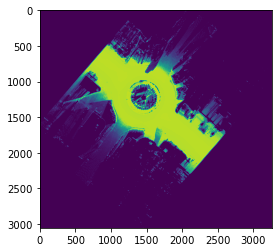

In [7]:
DTM = ground_las.proj_las_to_2D_plane(las_ground_npidxs, X_ground_ref[:,:,0], feature='z', operator='max' )
DTM[np.isnan(DTM)] = -1
plt.imshow(DTM)

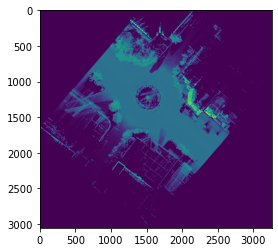

In [8]:
DSM = street_las.proj_las_to_2D_plane(las_npidxs, X_ref[:,:,0], feature='z', operator='max' )
DSM[np.isnan(DSM)] = -1
plt.imshow(DSM)

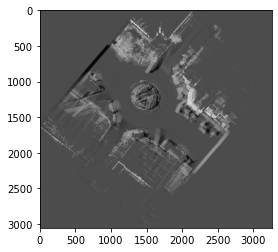

In [9]:
# DSM = street_las.proj_las_to_2D_plane(las_npidxs, X_ref[:,:,0], feature='z', operator='max' )
plt.imshow(DSM - DTM, cmap="gray")

(array([ 213076.,       0., 8789922.,  188031.,   21759.,  311599.,
         322036.,   43271.,   38895.,   11979.]),
 array([-27.13125   , -18.00055003,  -8.86985005,   0.26084992,
          9.39154989,  18.52224986,  27.65294984,  36.78364981,
         45.91434978,  55.04504976,  64.17574973]),
 <a list of 10 Patch objects>)

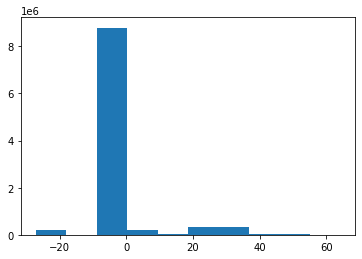

In [10]:
plt.hist(np.array(DSM - DTM).flatten())

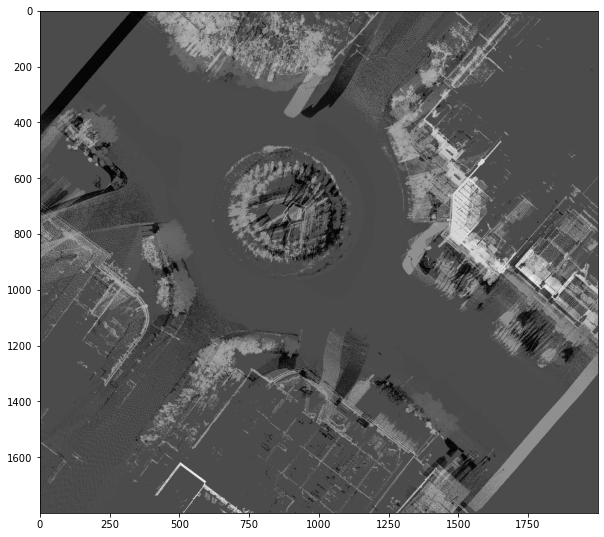

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
# DSM = street_las.proj_las_to_2D_plane(las_npidxs, X_ref[:,:,0], feature='z', operator='max' )
ax.imshow(np.array(DSM - DTM)[500:2300, 600:2600], cmap="gray")

In [12]:
from TronGisPy.TypeCast import convert_npdtype_to_gdaldtype
def write_output_tif(X, dst_tif_path, bands=None, cols=None, rows=None, geo_transform=None, projection=None, gdaldtype=None, no_data_value=None):
    """X should be in (n_rows, n_cols, n_bands) shape"""
    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=2)
    gdaldtype = convert_npdtype_to_gdaldtype(X.dtype) if gdaldtype is None else gdaldtype
    bands = X.shape[2] if bands is None else bands
    cols = X.shape[1] if cols is None else cols
    rows = X.shape[0] if rows is None else rows
    dst_ds = gdal.GetDriverByName('GTiff').Create(dst_tif_path, cols, rows, bands, gdaldtype) # dst_filename, xsize=512, ysize=512, bands=1, eType=gdal.GDT_Byte
    if geo_transform is not None:
        dst_ds.SetGeoTransform(geo_transform)
    if projection is not None:
        dst_ds.SetProjection(projection)

    for b in range(X.shape[2]):
        band = dst_ds.GetRasterBand(b+1)
        band.WriteArray(X[:, :, b], 0, 0)
        if no_data_value is not None:
            band.SetNoDataValue(no_data_value)
        band.FlushCache()
    print("No data value is :", dst_ds.GetRasterBand(1).GetNoDataValue())
    dst_ds = None


write_output_tif(DTM, "tmp/DTM.tif", geo_transform=geo_transform, projection=wkt_3826,
    gdaldtype=gdal.GDT_Int32, no_data_value=-1)

No data value is : -1.0


In [13]:
DSM[np.isnan(DSM)] == -1
GisIO.write_output_tif(DSM, "tmp/DSM.tif", geo_transform=geo_transform, projection=wkt_3826,
    gdaldtype=gdal.GDT_Int32, no_data_value=-1)

In [30]:
DSM_minusDTM = DSM - DTM
DSM_minusDTM[np.isnan(DSM_minusDTM)] == -1
GisIO.write_output_tif(DSM - DTM, "tmp/DSM_minusDTM.tif", geo_transform=geo_transform, projection=wkt_3826,
    gdaldtype=gdal.GDT_Float64)

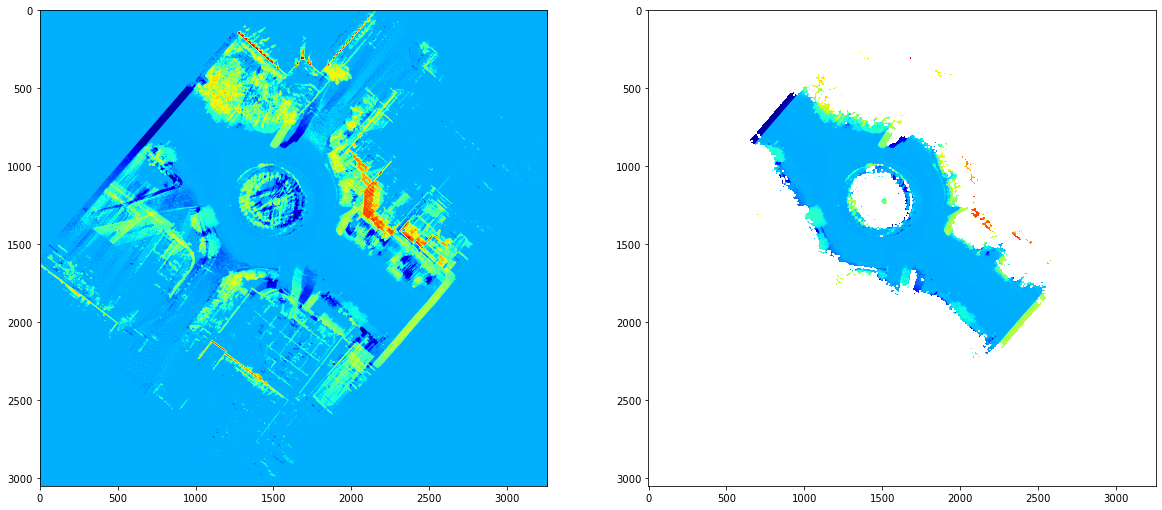

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20, 20))
# DSM = street_las.proj_las_to_2D_plane(las_npidxs, X_ref[:,:,0], feature='z', operator='max' )
tmp = np.array(DSM - DTM)
im = ax[0].imshow(tmp, cmap="jet")


tmp[tmp==0]=np.nan
im_1 = ax[1].imshow(tmp, cmap="jet")
# fig.colorbar(im, orientation="horizontal")